In [1]:
using ChangesOfVariables, InverseFunctions, ArraysOfArrays, Statistics
using Optimisers
using PyPlot
using Distributions

using Test
using ForwardDiff
using LinearAlgebra

# using Revise
using EuclidianNormalizingFlows

In [2]:
# Compare transformation results & gradients using ForwardDiff and and handwritten pullbacks.

function run_test_suite(; nrepetitions = 5,
        ndims = 5,
        nparams = 3,
        nsmpls = 50,
        dist = Uniform(-3, 3),
    )
    
    for i in 1:nrepetitions
        
        w = rand(dist, ndims, nparams)
        h = rand(dist, ndims, nparams)
        d = rand(dist, ndims, nparams-1)
        x = rand(Normal(0, 6), ndims, nsmpls)
        
        try 
            
            trafo_frwd = RationalQuadSpline(w,h,d)
            trafo_bcwd = RationalQuadSplineInv(w,h,d)

            x_fwd, jac_frwd = EuclidianNormalizingFlows.with_logabsdet_jacobian(trafo_frwd, x)
            x_bcwd, jac_bcwd = EuclidianNormalizingFlows.with_logabsdet_jacobian(trafo_bcwd, x_fwd) 

            @test x_bcwd ≈ x
            @test jac_frwd ≈ -jac_bcwd

            neg_ll, gradvals = EuclidianNormalizingFlows.mvnormal_negll_trafograd(trafo_frwd, x)

            a_run = ForwardDiff.gradient(par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(par,h,d), x), w)
            @test a_run ≈ gradvals.widths

            a_run = ForwardDiff.gradient(par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(w,par,d), x), h)
            @test a_run ≈ gradvals.heights

            a_run = ForwardDiff.gradient(par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(w,h,par), x), d)
            @test a_run ≈ gradvals.derivatives
            
            for j in 1:size(x, 2)
                xrun = x[:,j]
                autodiff_jac = ForwardDiff.jacobian(xtmp -> trafo_frwd(reshape(xtmp, ndims,1)), xrun )
                @test log(det(abs.(autodiff_jac))) ≈ jac_frwd[1,j] ≈ -jac_bcwd[1, j]
            end

        catch 
            print("Test error. Parameters: \n")
            @show w, h, d, x
        end
        
    end
end

run_test_suite()

# 2D fit: 

In [3]:
nparams = 15
nsmpls = 3000
ndims = 2
K = nparams

dist = Uniform(-1, 1)

trafo_truth = RationalQuadSplineInv(rand(dist, ndims, nparams),rand(dist, ndims, nparams),rand(dist, ndims, nparams-1))

y = rand(Normal(0, 1), ndims, nsmpls)
x = trafo_truth(y);

In [4]:
@test x ≈ RationalQuadSpline(trafo_truth.widths,trafo_truth.heights,trafo_truth.derivatives)(RationalQuadSplineInv(trafo_truth.widths,trafo_truth.heights,trafo_truth.derivatives)(x))

Test Passed
  Expression: x ≈ (RationalQuadSpline(trafo_truth.widths, trafo_truth.heights, trafo_truth.derivatives))((RationalQuadSplineInv(trafo_truth.widths, trafo_truth.heights, trafo_truth.derivatives))(x))
   Evaluated: [2.2975172165643682 2.035151324090566 … 1.9657881156555688 2.2274552801142957; 1.2869569289159823 1.1760058539520213 … 1.3616412994345906 1.7028812935484292] ≈ [2.297517216564368 2.0351513240905668 … 1.9657881156555688 2.227455280114297; 1.2869569289159826 1.1760058539520215 … 1.3616412994345903 1.7028812935484288]

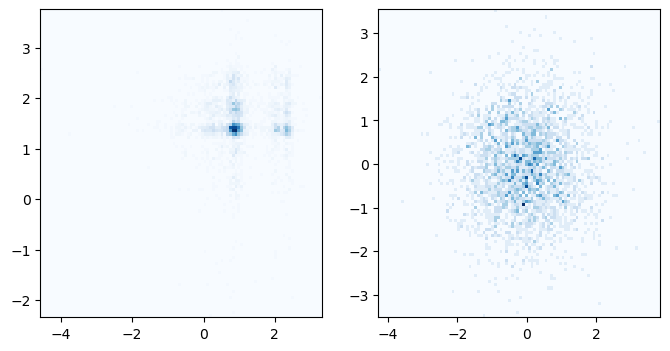

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-4.2767227290866785, -4.19542444991037, -4.114126170734062, -4.032827891557754, -3.9515296123814463, -3.8702313332051386, -3.7889330540288304, -3.7076347748525222, -3.626336495676214, -3.5450382164999064  …  3.121420675957352, 3.20271895513366, 3.2840172343099674, 3.3653155134862756, 3.4466137926625837, 3.527912071838892, 3.6092103510152, 3.690508630191508, 3.7718069093678164, 3.8531051885441236], [-3.5158826129976504, -3.445278819534709, -3.3746750260717677, -3.3040712326088264, -3.233467439145885, -3.1628636456829438, -3.0922598522200024, -3.0216560587570616, -2.95105226529412, -2.880448471831179  …  2.9090625921300077, 2.9796663855929486, 3.0502701790558904, 3.1208739725188313, 3.191477765981773, 3.262081559444714, 3.3326853529076548, 3.4032891463705965, 3.4738929398335374, 3.544496733296479], PyObject <matplotlib.collections.QuadMesh object at 0x7f98366d83d0>)

In [5]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(y[1,:], y[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

In [6]:
# initial_trafo = 
#     EuclidianNormalizingFlows.JohnsonTrafo([10.0, 11.0], [3.5, 3.6], [10.0, 11.0], [1.0, 1.1]) ∘
#     EuclidianNormalizingFlows.ScaleShiftTrafo(ones(ndims), zeros(ndims)) ∘  
#     RationalQuadSpline(ones(ndims, nparams), ones(ndims, nparams), ones(ndims, nparams-1))

# initial_trafo =  ScaleShiftTrafo(ones(ndims), zeros(ndims))

initial_trafo =  RationalQuadSpline(ones(ndims, nparams), ones(ndims, nparams), ones(ndims, nparams-1))

optimizer = ADAGrad()
smpls = nestedview(x)
nbatches = 20
nepochs = 10 

r = EuclidianNormalizingFlows.optimize_whitening(smpls, initial_trafo, optimizer, nbatches = nbatches, nepochs = nepochs)

(result = RationalQuadSpline([1.1207447635936003 1.1380837267574937 … 0.9081916891442511 0.9081916891442511; 1.2078067790911036 1.2078067790911036 … 0.9280837909499332 0.9280837909499332], [0.7397147737442563 0.7072495794496564 … 0.9948050030950936 0.9948050030950936; 0.618791150819249 0.618791150819249 … 1.0644266340570459 1.0644266340570459], [0.3358074327264176 0.5061041932468155 … 0.5068099928695221 1.0; 1.0 1.0 … 1.0345578589985187 1.0]), optimizer_state = (widths = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [6.47608 6.69442 … 10.8508 10.8508; 26.0724 26.0724 … 48.7509 48.7509]), heights = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [0.232927 0.232985 … 0.439732 0.439732; 0.545669 0.545669 … 1.0788 1.0788]), derivatives = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [6.82755e-5 5.29072e-6 … 6.65055e-6 1.19209e-7; 1.19209e-7 1.19209e-7 … 0.000133802 1.19209e-7])), negll_history = [4.105282565548604, 2.6227694817869884, 2.134395411687963, 2.0579818167929678, 2.051205060733441, 1.877087657263469

In [7]:
yhat = r.result(x)

2×3000 Matrix{Float64}:
  1.2457     0.811882   0.402522   0.58385  …  -0.136773   0.777499  1.06234
 -0.970349  -1.18354   -0.634268  -1.05587      1.19254   -0.575905  0.407317

In [8]:
@show mean(yhat, dims=2)
@show std(yhat, dims=2)

mean(yhat, dims = 2) = [-0.07093681689096937; -0.03815241370898611;;]
std(yhat, dims = 2) = [0.9804942985602443; 1.0160571281286717;;]


2×1 Matrix{Float64}:
 0.9804942985602443
 1.0160571281286717

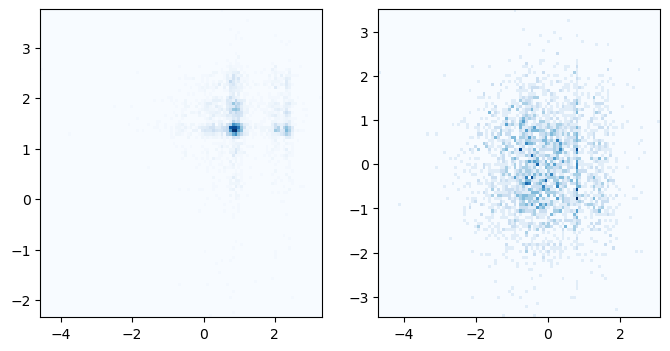

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-4.703160395456177, -4.625008501479962, -4.546856607503746, -4.468704713527531, -4.390552819551315, -4.3124009255751, -4.234249031598885, -4.15609713762267, -4.077945243646455, -3.9997933496702394  …  2.4086619563794125, 2.4868138503556274, 2.5649657443318423, 2.643117638308058, 2.721269532284273, 2.799421426260489, 2.8775733202367038, 2.9557252142129187, 3.0338771081891345, 3.1120290021653494], [-3.4640301355734255, -3.3942984315419373, -3.324566727510449, -3.254835023478961, -3.1851033194474727, -3.1153716154159845, -3.0456399113844963, -2.975908207353008, -2.90617650332152, -2.8364447992900317  …  2.881554931292002, 2.9512866353234903, 3.0210183393549785, 3.0907500433864667, 3.160481747417955, 3.230213451449444, 3.2999451554809323, 3.3696768595124205, 3.4394085635439087, 3.5091402675753973], PyObject <matplotlib.collections.QuadMesh object at 0x7f98384c4f70>)

In [9]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(yhat[1,:], yhat[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

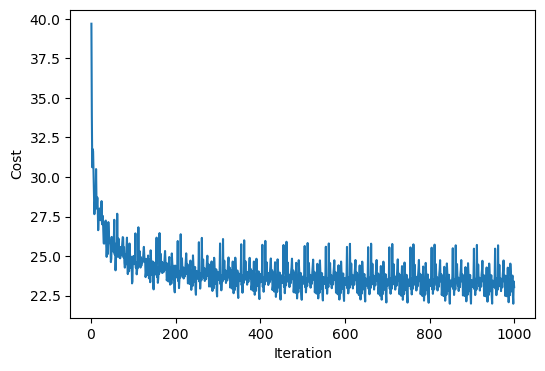

PyObject Text(0.5, 24.0, 'Iteration')

In [23]:
fig, ax = plt.subplots(1,1,  figsize=(6,4))

ax.plot(1:length(r.negll_history), r.negll_history)
ax.set_ylabel("Cost")
ax.set_xlabel("Iteration")

# 20D fit: 

In [11]:
nparams = 20 # 1180 parameters in total
nsmpls = 2000
ndims = 20
K = nparams
dist = Uniform(-1, 1)

y = rand(Normal(0, 1), ndims, nsmpls);

In [12]:
bwd_true =
#     EuclidianNormalizingFlows.ScaleShiftTrafo([1., 0.4], [2.5, -1.2]) ∘
#     EuclidianNormalizingFlows.HouseholderTrafo([1.0, 0.3]) ∘
#     EuclidianNormalizingFlows.CenterStretch([1.0, 0.1], [2.0, 2.1], [1.0, 1.1]) ∘
    RationalQuadSplineInv(rand(dist, ndims, nparams),rand(dist, ndims, nparams),rand(dist, ndims, nparams-1))

x = bwd_true(y)

20×2000 Matrix{Float64}:
  0.937374   -1.35623   -0.365631  …   1.91322     1.1328      1.30836
 -0.263172   -1.69066   -1.41497      -1.59527    -2.80031    -3.08272
 -0.40051    -0.449773  -2.98724      -2.9982     -2.20748    -1.60661
 -0.212169    0.938072   2.92696       0.411929    0.0460008   2.88553
  1.8182      0.496594   0.77651      -0.0412627   0.455873    1.93845
  0.248663   -1.02421   -0.626043  …  -0.0105981  -1.49687    -0.352656
  1.89543     0.601672  -0.247179      0.560643    0.896777    0.748584
  1.14298     0.236359   1.59279       0.461449    1.8892      1.6812
  2.18419     1.39752    0.547524     -0.72471    -0.707585    1.46529
  0.942353    1.96563    0.164544     -0.776935    0.262422    1.0839
 -1.996       0.957755  -2.54014   …  -2.15803     0.247531   -0.657262
  1.51735     0.17905   -0.448168     -0.0231863  -1.05751     0.720776
  0.260511    0.743387  -0.150629     -0.450281   -2.13942    -0.186437
 -0.96529    -0.470416   2.72202       2.36024   

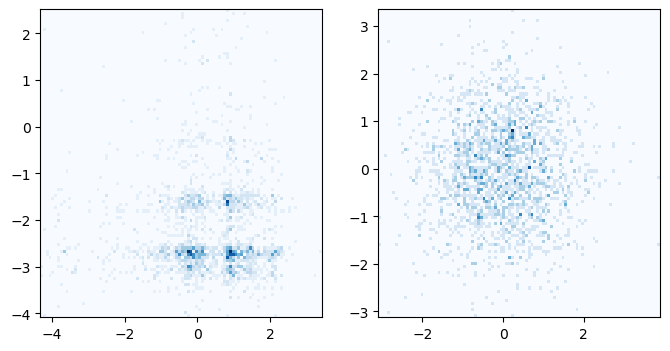

In [13]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(y[1,:], y[2,:], 100, cmap="Blues");
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

In [14]:
initial_trafo = 
    RationalQuadSpline(ones(ndims, 40), ones(ndims, 40), ones(ndims, 40-1)) #∘
#     EuclidianNormalizingFlows.ScaleShiftTrafo([1., 1], [2., 2]) 

optimizer = ADAGrad(0.1)
smpls = nestedview(x)
nbatches = 50
nepochs = 20 

r = EuclidianNormalizingFlows.optimize_whitening(smpls, initial_trafo, optimizer, nbatches = nbatches, nepochs = nepochs);

In [15]:
yhat = r.result(x);

In [16]:
@show mean(yhat, dims=2)
@show std(yhat, dims=2);

mean(yhat, dims = 2) = [-0.03798766476998578; -0.02723836494453642; 0.0431444524364355; 0.03232598221291205; 0.05214726226485697; 0.012199947342000719; -0.01246406264135512; -0.007699901582739036; 0.011440580264842005; -0.016527359186067084; 0.005936242083225194; -0.026811687229843898; 0.04893388153726574; -0.030147596018332636; -0.0072496222838567504; -0.005253715776926796; -0.035592803899961244; -0.0018728755591863643; -0.011361922338656905; -0.02347540362205668;;]
std(yhat, dims = 2) = [1.0007500291874887; 1.005790784374785; 1.017564946460844; 0.9965126073274702; 0.9966812726554617; 1.004262705791574; 1.0093314156836892; 0.985343707092972; 0.9989191406173423; 0.9995178269418254; 1.0049271959641566; 1.0073127539637028; 1.006271385262499; 0.9980225626367427; 1.0025536224191163; 1.0055200154861186; 1.0103793710206679; 0.9948539822324505; 0.99830441004035; 1.0154781118977128;;]


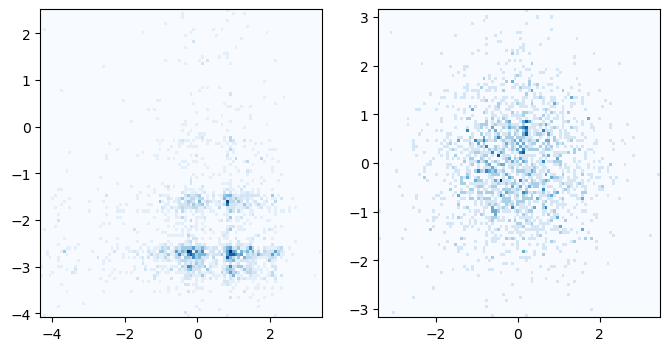

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-3.395252601351036, -3.3266048434727913, -3.2579570855945463, -3.189309327716302, -3.120661569838057, -3.0520138119598124, -2.983366054081568, -2.914718296203323, -2.8460705383250784, -2.777422780446834  …  2.85169336556923, 2.920341123447474, 2.988988881325719, 3.057636639203964, 3.126284397082208, 3.194932154960453, 3.263579912838698, 3.332227670716942, 3.400875428595187, 3.4695231864734315], [-3.169856589155763, -3.106576715170206, -3.0432968411846497, -2.980016967199093, -2.916737093213536, -2.853457219227979, -2.790177345242422, -2.7268974712568657, -2.6636175972713088, -2.600337723285752  …  2.5886119435299046, 2.651891817515461, 2.7151716915010184, 2.778451565486575, 2.8417314394721322, 2.9050113134576887, 2.968291187443245, 3.0315710614288025, 3.094850935414359, 3.158130809399916], PyObject <matplotlib.collections.QuadMesh object at 0x7f983608df40>)

In [20]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(yhat[1,:], yhat[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

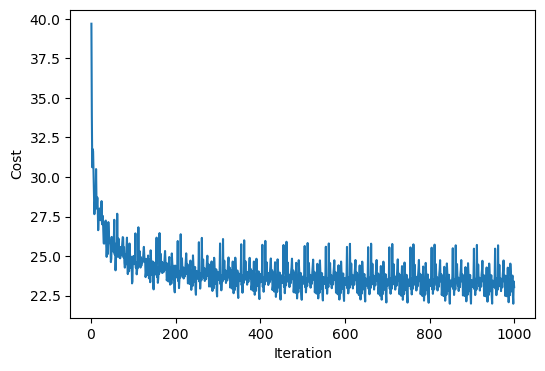

PyObject Text(0.5, 24.0, 'Iteration')

In [21]:
fig, ax = plt.subplots(1,1,  figsize=(6,4))

ax.plot(1:length(r.negll_history), r.negll_history)
ax.set_ylabel("Cost")
ax.set_xlabel("Iteration")